# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [2]:
train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

In [3]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [4]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [5]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

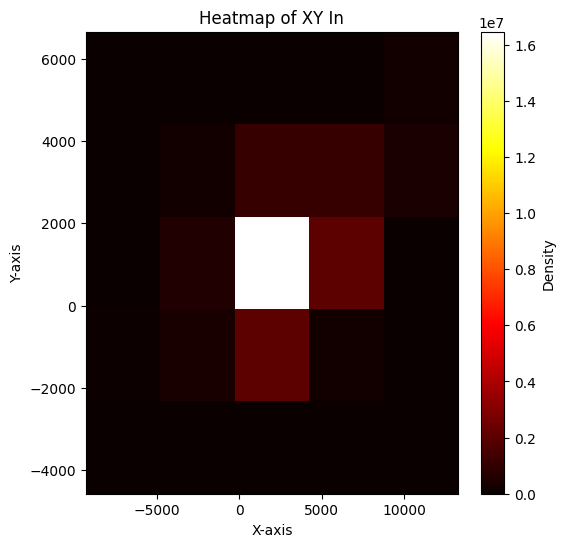

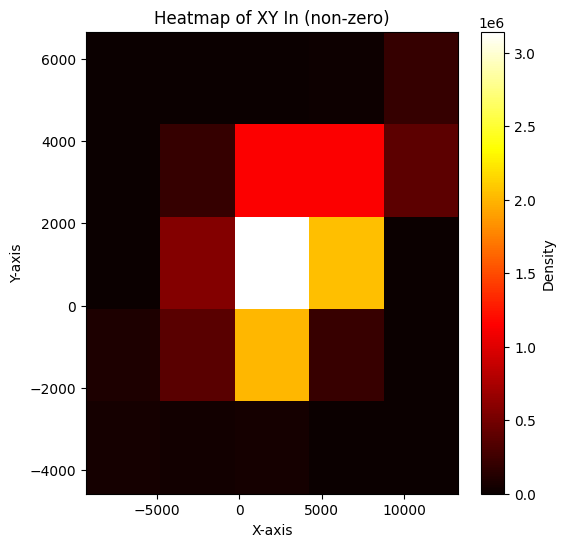

In [6]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

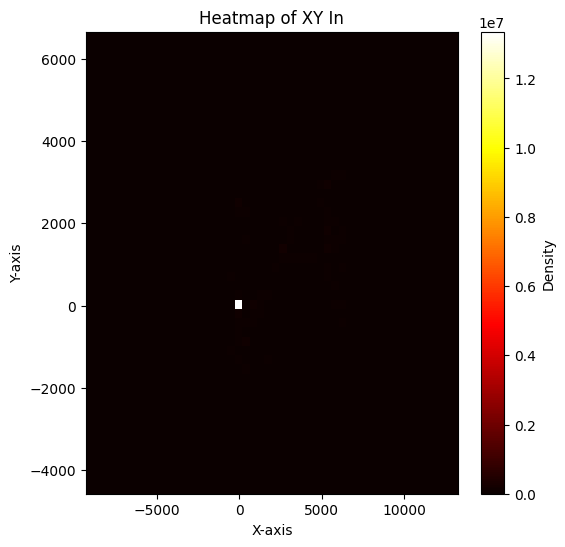

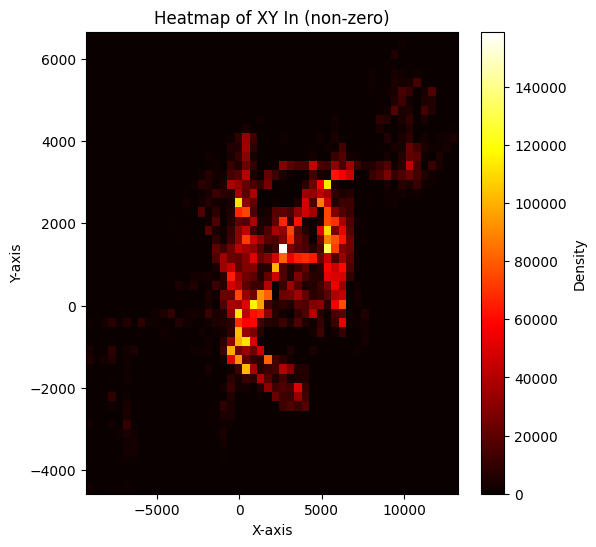

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [8]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True, input_len=50, future_len=60, sliding_window=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment
        self.input_len = input_len
        self.future_len = future_len
        self.sliding_window = sliding_window

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        total_len = scene.shape[1]  # should be 110
        # Sliding window: pick a random start if enabled
        if self.sliding_window:
            max_start = total_len - (self.input_len + self.future_len)
            t0 = np.random.randint(0, max_start + 1) if max_start > 0 else 0
        else:
            t0 = 0

        hist = scene[:, t0:t0+self.input_len, :].copy()    # (agents=50, input_len, 6)
        future = torch.tensor(scene[0, t0+self.input_len:t0+self.input_len+self.future_len, :2].copy(), dtype=torch.float32)  # (future_len, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [9]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x)
)
val_dataloader = DataLoader(
    val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
)

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [10]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [11]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

#### Trying Transformer Model

In [13]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=6, model_dim=128, num_heads=4, num_layers=2, output_dim=60*2, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, output_dim)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent index 0, shape: (batch, 50, 6)
        x = self.input_proj(x)  # (batch, 50, model_dim)
        x = self.transformer_encoder(x)  # (batch, 50, model_dim)
        out = self.fc(x[:, -1, :])  # Use last time step's output
        return out.view(-1, 60, 2)

In [14]:
class AdvancedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len
        self.input_proj = nn.Linear(input_dim, model_dim)
        
        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*4,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Decoder for future trajectory
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch, agents, seq, features)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        x = self.input_proj(x)  # (batch, seq, model_dim)
        x = x + self.pos_encoding[:, :self.seq_len, :]  # Add positional encoding
        x = self.encoder(x)  # (batch, seq, model_dim)
        x = x[:, -1, :]  # Use last time step's output (batch, model_dim)
        out = self.decoder(x)  # (batch, future_len*2)
        return out.view(-1, self.future_len, 2)

In [15]:
class BeefedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len

        # Temporal convolution for local feature extraction
        self.temporal_conv = nn.Conv1d(input_dim, input_dim, kernel_size=3, padding=1, groups=input_dim)
        self.input_proj = nn.Linear(input_dim, model_dim)

        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*6,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Deeper MLP decoder with residual connection
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim*2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim*2, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        # Temporal convolution
        x = x.transpose(1, 2)  # (batch, features, seq)
        x = self.temporal_conv(x)
        x = x.transpose(1, 2)  # (batch, seq, features)
        x = self.input_proj(x)
        x = x + self.pos_encoding[:, :self.seq_len, :]
        x = self.encoder(x)
        x = x[:, -1, :]  # Last time step
        out = self.decoder(x)
        return out.view(-1, self.future_len, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [16]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
# model = TransformerModel().to(device)
# model = AdvancedTransformerModel().to(device)
# model = AdvancedTransformerModel(
#     input_dim=6,
#     model_dim=512,      # 2x wider
#     num_heads=16,       # 2x more heads
#     num_layers=12,      # 2x deeper
#     seq_len=50,
#     future_len=60,
#     dropout=0.10        # Slightly higher dropout for regularization
# ).to(device)
# model = BeefedTransformerModel(
#     input_dim=6,
#     model_dim=1152,
#     num_heads=36,
#     num_layers=20,
#     seq_len=50,
#     future_len=60,
#     dropout=0.15
# ).to(device)
# model_dim=128, num_heads=4, num_layers=2


In [17]:
from s4.models.s4.s4d import S4D

class S4TrajectoryModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=128,
        num_layers=2,
        seq_len=50,
        future_len=60,
        dropout=0.1
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.s4_layers = nn.ModuleList([
            S4D(model_dim, dropout=dropout, transposed=True) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(model_dim)
        self.head = nn.Linear(model_dim, future_len * 2)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        x = self.input_proj(x)  # (batch, seq, model_dim)
        x = x.transpose(1, 2)   # (batch, model_dim, seq) for S4D
        for layer in self.s4_layers:
            x, _ = layer(x)
        x = x.transpose(1, 2)   # (batch, seq, model_dim)
        x = self.norm(x[:, -1, :])  # Use last time step
        out = self.head(x)
        return out.view(-1, self.future_len, 2)

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [18]:
from sklearn.model_selection import KFold

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
all_indices = np.arange(len(train_data))
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices)):
    print(f"\n--- Fold {fold+1}/{k_folds} ---")

    # Create datasets for this fold
    train_dataset = TrajectoryDatasetTrain(train_data[train_idx], scale=scale, augment=True)
    val_dataset = TrajectoryDatasetTrain(train_data[val_idx], scale=scale, augment=False, sliding_window=False)
    train_dataloader = DataLoader(
        train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x)
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
    )
    
    model = S4TrajectoryModel(
        input_dim=6,
        model_dim=256,
        num_layers=4,
        seq_len=50,
        future_len=60,
        dropout=0
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
    early_stopping_patience = 20
    best_val_loss = float('inf')
    no_improvement = 0
    criterion = nn.MSELoss()

    for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item()
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                val_loss += criterion(pred, y).item()

                # show MAE and MSE with unnormalized data
                pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                val_mae += nn.L1Loss()(pred, y).item()
                val_mse += nn.MSELoss()(pred, y).item()
        
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_mse /= len(val_dataloader)
        scheduler.step()
        # scheduler.step(val_loss)
        
        tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), f"best_model_fold{fold+1}.pt")
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print("Early stop!")
                break

    fold_results.append(best_val_loss)

print(f"\nK-Fold Results: {fold_results}")
print(f"Mean Validation Loss: {np.mean(fold_results):.4f} | Std: {np.std(fold_results):.4f}")


--- Fold 1/5 ---


Epoch:   1%|          | 1/100 [00:04<07:14,  4.39s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.3420 | val normalized MSE   0.4508, | val MAE   2.7586 | val MSE  22.0904


Epoch:   2%|▏         | 2/100 [00:08<06:40,  4.09s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.3483 | val normalized MSE   0.3352, | val MAE   2.4081 | val MSE  16.4236


Epoch:   3%|▎         | 3/100 [00:12<06:37,  4.10s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.2871 | val normalized MSE   0.2902, | val MAE   2.0996 | val MSE  14.2214


Epoch:   4%|▍         | 4/100 [00:16<06:41,  4.18s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.2603 | val normalized MSE   0.2625, | val MAE   1.9919 | val MSE  12.8608


Epoch:   5%|▌         | 5/100 [00:20<06:38,  4.19s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.2421 | val normalized MSE   0.2434, | val MAE   1.8682 | val MSE  11.9289


Epoch:   6%|▌         | 6/100 [00:25<06:33,  4.19s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.2410 | val normalized MSE   0.2378, | val MAE   1.7540 | val MSE  11.6535


Epoch:   7%|▋         | 7/100 [00:29<06:33,  4.23s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2346 | val normalized MSE   0.2535, | val MAE   1.9063 | val MSE  12.4217


Epoch:   8%|▊         | 8/100 [00:33<06:25,  4.19s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2260 | val normalized MSE   0.2281, | val MAE   1.7540 | val MSE  11.1770


Epoch:   9%|▉         | 9/100 [00:37<06:17,  4.15s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2310 | val normalized MSE   0.2388, | val MAE   1.8133 | val MSE  11.7027


Epoch:  10%|█         | 10/100 [00:41<06:12,  4.14s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2264 | val normalized MSE   0.2135, | val MAE   1.6890 | val MSE  10.4603


Epoch:  11%|█         | 11/100 [00:45<06:11,  4.17s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2164 | val normalized MSE   0.2273, | val MAE   1.7119 | val MSE  11.1389


Epoch:  12%|█▏        | 12/100 [00:50<06:06,  4.17s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2172 | val normalized MSE   0.2279, | val MAE   1.6934 | val MSE  11.1688


Epoch:  13%|█▎        | 13/100 [00:54<06:03,  4.18s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2134 | val normalized MSE   0.2144, | val MAE   1.6921 | val MSE  10.5053


Epoch:  14%|█▍        | 14/100 [00:58<05:59,  4.18s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2108 | val normalized MSE   0.2191, | val MAE   1.7070 | val MSE  10.7363


Epoch:  15%|█▌        | 15/100 [01:02<05:55,  4.19s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2195 | val normalized MSE   0.2160, | val MAE   1.6537 | val MSE  10.5859


Epoch:  16%|█▌        | 16/100 [01:06<05:51,  4.19s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2089 | val normalized MSE   0.2153, | val MAE   1.7028 | val MSE  10.5486


Epoch:  17%|█▋        | 17/100 [01:10<05:43,  4.14s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2096 | val normalized MSE   0.2254, | val MAE   1.8239 | val MSE  11.0453


Epoch:  18%|█▊        | 18/100 [01:14<05:33,  4.07s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2184 | val normalized MSE   0.2229, | val MAE   1.8007 | val MSE  10.9238


Epoch:  19%|█▉        | 19/100 [01:18<05:29,  4.06s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2085 | val normalized MSE   0.2196, | val MAE   1.6510 | val MSE  10.7598


Epoch:  20%|██        | 20/100 [01:22<05:23,  4.05s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2118 | val normalized MSE   0.2253, | val MAE   1.8011 | val MSE  11.0396


Epoch:  21%|██        | 21/100 [01:27<05:22,  4.09s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.1892 | val normalized MSE   0.1975, | val MAE   1.4975 | val MSE   9.6792


Epoch:  22%|██▏       | 22/100 [01:30<05:14,  4.04s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.1870 | val normalized MSE   0.1961, | val MAE   1.4980 | val MSE   9.6105


Epoch:  23%|██▎       | 23/100 [01:35<05:14,  4.08s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.1886 | val normalized MSE   0.1947, | val MAE   1.4554 | val MSE   9.5388


Epoch:  24%|██▍       | 24/100 [01:39<05:20,  4.22s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.1876 | val normalized MSE   0.1974, | val MAE   1.5144 | val MSE   9.6750


Epoch:  25%|██▌       | 25/100 [01:43<05:12,  4.16s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.1867 | val normalized MSE   0.1984, | val MAE   1.4929 | val MSE   9.7195


Epoch:  26%|██▌       | 26/100 [01:47<05:03,  4.10s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.1866 | val normalized MSE   0.1957, | val MAE   1.4932 | val MSE   9.5891


Epoch:  27%|██▋       | 27/100 [01:51<04:57,  4.08s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.1864 | val normalized MSE   0.1956, | val MAE   1.4710 | val MSE   9.5868


Epoch:  28%|██▊       | 28/100 [01:55<04:51,  4.05s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.1873 | val normalized MSE   0.1974, | val MAE   1.4923 | val MSE   9.6710


Epoch:  29%|██▉       | 29/100 [01:59<04:45,  4.03s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.1863 | val normalized MSE   0.1980, | val MAE   1.5037 | val MSE   9.7040


Epoch:  30%|███       | 30/100 [02:03<04:37,  3.97s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.1862 | val normalized MSE   0.1987, | val MAE   1.5040 | val MSE   9.7370


Epoch:  31%|███       | 31/100 [02:07<04:28,  3.90s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.1869 | val normalized MSE   0.1979, | val MAE   1.4876 | val MSE   9.6954


Epoch:  32%|███▏      | 32/100 [02:10<04:22,  3.86s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.1868 | val normalized MSE   0.1975, | val MAE   1.4706 | val MSE   9.6755


Epoch:  33%|███▎      | 33/100 [02:14<04:16,  3.83s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.1856 | val normalized MSE   0.2010, | val MAE   1.5182 | val MSE   9.8510


Epoch:  34%|███▍      | 34/100 [02:18<04:13,  3.84s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.1877 | val normalized MSE   0.1997, | val MAE   1.5074 | val MSE   9.7842


Epoch:  35%|███▌      | 35/100 [02:22<04:10,  3.85s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.1850 | val normalized MSE   0.1981, | val MAE   1.5342 | val MSE   9.7057


Epoch:  36%|███▌      | 36/100 [02:26<04:07,  3.86s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.1863 | val normalized MSE   0.1964, | val MAE   1.5117 | val MSE   9.6248


Epoch:  37%|███▋      | 37/100 [02:30<04:07,  3.92s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.1846 | val normalized MSE   0.1950, | val MAE   1.5122 | val MSE   9.5557


Epoch:  38%|███▊      | 38/100 [02:34<04:05,  3.96s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.1854 | val normalized MSE   0.2006, | val MAE   1.5245 | val MSE   9.8309


Epoch:  39%|███▉      | 39/100 [02:38<04:04,  4.01s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.1856 | val normalized MSE   0.2007, | val MAE   1.5220 | val MSE   9.8333


Epoch:  40%|████      | 40/100 [02:42<04:01,  4.03s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.1861 | val normalized MSE   0.2007, | val MAE   1.5224 | val MSE   9.8333


Epoch:  41%|████      | 41/100 [02:46<03:59,  4.06s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1809 | val normalized MSE   0.1950, | val MAE   1.4515 | val MSE   9.5544


Epoch:  42%|████▏     | 42/100 [02:51<04:09,  4.30s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1806 | val normalized MSE   0.1936, | val MAE   1.4566 | val MSE   9.4864


Epoch:  43%|████▎     | 43/100 [02:55<04:02,  4.25s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1787 | val normalized MSE   0.1937, | val MAE   1.4360 | val MSE   9.4916


Epoch:  44%|████▍     | 44/100 [02:59<03:54,  4.18s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1798 | val normalized MSE   0.1925, | val MAE   1.4250 | val MSE   9.4347


Epoch:  45%|████▌     | 45/100 [03:04<03:50,  4.19s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1793 | val normalized MSE   0.1931, | val MAE   1.4394 | val MSE   9.4612


Epoch:  46%|████▌     | 46/100 [03:08<03:43,  4.13s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1790 | val normalized MSE   0.1942, | val MAE   1.4396 | val MSE   9.5173


Epoch:  47%|████▋     | 47/100 [03:12<03:37,  4.11s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1787 | val normalized MSE   0.1938, | val MAE   1.4365 | val MSE   9.4943


Epoch:  48%|████▊     | 48/100 [03:16<03:37,  4.18s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1793 | val normalized MSE   0.1939, | val MAE   1.4527 | val MSE   9.5030


Epoch:  49%|████▉     | 49/100 [03:21<03:39,  4.30s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1792 | val normalized MSE   0.1943, | val MAE   1.4369 | val MSE   9.5213


Epoch:  50%|█████     | 50/100 [03:25<03:32,  4.26s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1804 | val normalized MSE   0.1932, | val MAE   1.4519 | val MSE   9.4665


Epoch:  51%|█████     | 51/100 [03:29<03:29,  4.28s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1791 | val normalized MSE   0.1941, | val MAE   1.4370 | val MSE   9.5125


Epoch:  52%|█████▏    | 52/100 [03:34<03:28,  4.35s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1798 | val normalized MSE   0.1926, | val MAE   1.4293 | val MSE   9.4384


Epoch:  53%|█████▎    | 53/100 [03:38<03:27,  4.41s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1800 | val normalized MSE   0.1934, | val MAE   1.4439 | val MSE   9.4751


Epoch:  54%|█████▍    | 54/100 [03:42<03:20,  4.35s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1786 | val normalized MSE   0.1954, | val MAE   1.4834 | val MSE   9.5732


Epoch:  55%|█████▌    | 55/100 [03:46<03:13,  4.30s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1788 | val normalized MSE   0.1931, | val MAE   1.4337 | val MSE   9.4608


Epoch:  56%|█████▌    | 56/100 [03:50<03:05,  4.22s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1779 | val normalized MSE   0.1930, | val MAE   1.4511 | val MSE   9.4581


Epoch:  57%|█████▋    | 57/100 [03:55<03:01,  4.21s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1794 | val normalized MSE   0.1919, | val MAE   1.4574 | val MSE   9.4048


Epoch:  58%|█████▊    | 58/100 [03:59<02:56,  4.21s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1788 | val normalized MSE   0.1918, | val MAE   1.4239 | val MSE   9.3969


Epoch:  59%|█████▉    | 59/100 [04:03<02:52,  4.20s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1797 | val normalized MSE   0.1928, | val MAE   1.4486 | val MSE   9.4460


Epoch:  60%|██████    | 60/100 [04:07<02:46,  4.16s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1789 | val normalized MSE   0.1918, | val MAE   1.4295 | val MSE   9.3973


Epoch:  61%|██████    | 61/100 [04:11<02:41,  4.15s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1783 | val normalized MSE   0.1913, | val MAE   1.4174 | val MSE   9.3745


Epoch:  62%|██████▏   | 62/100 [04:16<02:40,  4.21s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1776 | val normalized MSE   0.1910, | val MAE   1.4067 | val MSE   9.3592


Epoch:  63%|██████▎   | 63/100 [04:20<02:37,  4.26s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1766 | val normalized MSE   0.1916, | val MAE   1.4187 | val MSE   9.3894


Epoch:  64%|██████▍   | 64/100 [04:24<02:31,  4.21s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1772 | val normalized MSE   0.1913, | val MAE   1.4139 | val MSE   9.3738


Epoch:  65%|██████▌   | 65/100 [04:28<02:26,  4.20s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1774 | val normalized MSE   0.1915, | val MAE   1.4123 | val MSE   9.3814


Epoch:  66%|██████▌   | 66/100 [04:33<02:25,  4.29s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1778 | val normalized MSE   0.1916, | val MAE   1.4063 | val MSE   9.3864


Epoch:  67%|██████▋   | 67/100 [04:37<02:22,  4.31s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1774 | val normalized MSE   0.1915, | val MAE   1.4105 | val MSE   9.3857


Epoch:  68%|██████▊   | 68/100 [04:42<02:19,  4.36s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1778 | val normalized MSE   0.1918, | val MAE   1.4149 | val MSE   9.3967


Epoch:  69%|██████▉   | 69/100 [04:46<02:15,  4.38s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1769 | val normalized MSE   0.1916, | val MAE   1.4117 | val MSE   9.3883


Epoch:  70%|███████   | 70/100 [04:50<02:09,  4.30s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1769 | val normalized MSE   0.1911, | val MAE   1.4099 | val MSE   9.3618


Epoch:  71%|███████   | 71/100 [04:54<02:04,  4.30s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1776 | val normalized MSE   0.1914, | val MAE   1.4156 | val MSE   9.3807


Epoch:  72%|███████▏  | 72/100 [04:59<02:01,  4.33s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1781 | val normalized MSE   0.1913, | val MAE   1.4122 | val MSE   9.3759


Epoch:  73%|███████▎  | 73/100 [05:03<01:55,  4.30s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1772 | val normalized MSE   0.1911, | val MAE   1.4083 | val MSE   9.3632


Epoch:  74%|███████▍  | 74/100 [05:07<01:50,  4.24s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1774 | val normalized MSE   0.1907, | val MAE   1.4085 | val MSE   9.3420


Epoch:  75%|███████▌  | 75/100 [05:11<01:44,  4.19s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1778 | val normalized MSE   0.1912, | val MAE   1.4224 | val MSE   9.3704


Epoch:  76%|███████▌  | 76/100 [05:15<01:40,  4.20s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1766 | val normalized MSE   0.1911, | val MAE   1.4207 | val MSE   9.3639


Epoch:  77%|███████▋  | 77/100 [05:20<01:37,  4.22s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1773 | val normalized MSE   0.1915, | val MAE   1.4113 | val MSE   9.3817


Epoch:  78%|███████▊  | 78/100 [05:24<01:32,  4.21s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1769 | val normalized MSE   0.1917, | val MAE   1.4179 | val MSE   9.3921


Epoch:  79%|███████▉  | 79/100 [05:28<01:26,  4.13s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1774 | val normalized MSE   0.1917, | val MAE   1.4308 | val MSE   9.3941


Epoch:  80%|████████  | 80/100 [05:32<01:22,  4.10s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1763 | val normalized MSE   0.1919, | val MAE   1.4191 | val MSE   9.4021


Epoch:  81%|████████  | 81/100 [05:36<01:18,  4.12s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1779 | val normalized MSE   0.1918, | val MAE   1.4061 | val MSE   9.3972


Epoch:  82%|████████▏ | 82/100 [05:40<01:14,  4.12s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1765 | val normalized MSE   0.1913, | val MAE   1.4088 | val MSE   9.3737


Epoch:  83%|████████▎ | 83/100 [05:45<01:12,  4.24s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1769 | val normalized MSE   0.1914, | val MAE   1.4085 | val MSE   9.3776


Epoch:  84%|████████▍ | 84/100 [05:49<01:07,  4.20s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1759 | val normalized MSE   0.1915, | val MAE   1.4074 | val MSE   9.3822


Epoch:  85%|████████▌ | 85/100 [05:53<01:02,  4.15s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1770 | val normalized MSE   0.1911, | val MAE   1.4056 | val MSE   9.3660


Epoch:  86%|████████▌ | 86/100 [05:57<00:57,  4.09s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1772 | val normalized MSE   0.1913, | val MAE   1.4060 | val MSE   9.3736


Epoch:  87%|████████▋ | 87/100 [06:01<00:52,  4.05s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1771 | val normalized MSE   0.1912, | val MAE   1.4081 | val MSE   9.3663


Epoch:  88%|████████▊ | 88/100 [06:05<00:47,  3.99s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1771 | val normalized MSE   0.1913, | val MAE   1.4102 | val MSE   9.3723


Epoch:  89%|████████▉ | 89/100 [06:08<00:43,  3.96s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1763 | val normalized MSE   0.1911, | val MAE   1.4061 | val MSE   9.3619


Epoch:  90%|█████████ | 90/100 [06:12<00:39,  3.96s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1764 | val normalized MSE   0.1913, | val MAE   1.4066 | val MSE   9.3722


Epoch:  91%|█████████ | 91/100 [06:16<00:35,  3.97s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1770 | val normalized MSE   0.1914, | val MAE   1.4068 | val MSE   9.3775


Epoch:  92%|█████████▏| 92/100 [06:20<00:31,  3.94s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1772 | val normalized MSE   0.1912, | val MAE   1.4110 | val MSE   9.3685


Epoch:  93%|█████████▎| 93/100 [06:24<00:27,  3.99s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1766 | val normalized MSE   0.1910, | val MAE   1.4082 | val MSE   9.3592


Epoch:  93%|█████████▎| 93/100 [06:28<00:29,  4.18s/epoch]


Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1774 | val normalized MSE   0.1910, | val MAE   1.4080 | val MSE   9.3612
Early stop!

--- Fold 2/5 ---


Epoch:   1%|          | 1/100 [00:04<06:53,  4.18s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.2072 | val normalized MSE   0.5041, | val MAE   3.0631 | val MSE  24.7010


Epoch:   2%|▏         | 2/100 [00:08<06:44,  4.13s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.3549 | val normalized MSE   0.2831, | val MAE   1.9866 | val MSE  13.8705


Epoch:   3%|▎         | 3/100 [00:12<06:34,  4.06s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.2869 | val normalized MSE   0.2649, | val MAE   1.9612 | val MSE  12.9822


Epoch:   4%|▍         | 4/100 [00:16<06:29,  4.05s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.2616 | val normalized MSE   0.2846, | val MAE   2.0434 | val MSE  13.9458


Epoch:   5%|▌         | 5/100 [00:20<06:24,  4.04s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.2480 | val normalized MSE   0.2521, | val MAE   1.8874 | val MSE  12.3537


Epoch:   6%|▌         | 6/100 [00:24<06:19,  4.04s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.2472 | val normalized MSE   0.2421, | val MAE   1.7819 | val MSE  11.8625


Epoch:   7%|▋         | 7/100 [00:28<06:16,  4.04s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2342 | val normalized MSE   0.2224, | val MAE   1.6879 | val MSE  10.8982


Epoch:   8%|▊         | 8/100 [00:32<06:22,  4.15s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2287 | val normalized MSE   0.2404, | val MAE   1.8463 | val MSE  11.7793


Epoch:   9%|▉         | 9/100 [00:37<06:21,  4.20s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2316 | val normalized MSE   0.2161, | val MAE   1.6700 | val MSE  10.5866


Epoch:  10%|█         | 10/100 [00:41<06:19,  4.21s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2266 | val normalized MSE   0.2171, | val MAE   1.6816 | val MSE  10.6395


Epoch:  11%|█         | 11/100 [00:45<06:13,  4.19s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2222 | val normalized MSE   0.2184, | val MAE   1.7550 | val MSE  10.7000


Epoch:  12%|█▏        | 12/100 [00:50<06:19,  4.31s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2145 | val normalized MSE   0.2594, | val MAE   2.0127 | val MSE  12.7103


Epoch:  13%|█▎        | 13/100 [00:54<06:11,  4.27s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2226 | val normalized MSE   0.2118, | val MAE   1.6867 | val MSE  10.3801


Epoch:  14%|█▍        | 14/100 [00:58<06:06,  4.26s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2139 | val normalized MSE   0.2223, | val MAE   1.8922 | val MSE  10.8912


Epoch:  15%|█▌        | 15/100 [01:02<06:06,  4.31s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2220 | val normalized MSE   0.2225, | val MAE   1.7793 | val MSE  10.9017


Epoch:  16%|█▌        | 16/100 [01:07<06:03,  4.33s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2117 | val normalized MSE   0.2226, | val MAE   1.7461 | val MSE  10.9073


Epoch:  17%|█▋        | 17/100 [01:11<05:55,  4.28s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2078 | val normalized MSE   0.2196, | val MAE   1.6859 | val MSE  10.7616


Epoch:  18%|█▊        | 18/100 [01:15<05:52,  4.30s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2089 | val normalized MSE   0.2231, | val MAE   1.7784 | val MSE  10.9297


Epoch:  19%|█▉        | 19/100 [01:19<05:39,  4.19s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2108 | val normalized MSE   0.2178, | val MAE   1.7404 | val MSE  10.6744


Epoch:  20%|██        | 20/100 [01:23<05:35,  4.20s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2096 | val normalized MSE   0.2128, | val MAE   1.6496 | val MSE  10.4255


Epoch:  21%|██        | 21/100 [01:28<05:29,  4.17s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.1946 | val normalized MSE   0.2001, | val MAE   1.5030 | val MSE   9.8069


Epoch:  22%|██▏       | 22/100 [01:32<05:23,  4.15s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.1884 | val normalized MSE   0.1914, | val MAE   1.4725 | val MSE   9.3807


Epoch:  23%|██▎       | 23/100 [01:36<05:15,  4.09s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.1886 | val normalized MSE   0.1940, | val MAE   1.5066 | val MSE   9.5063


Epoch:  24%|██▍       | 24/100 [01:40<05:08,  4.06s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.1891 | val normalized MSE   0.1972, | val MAE   1.5169 | val MSE   9.6614


Epoch:  25%|██▌       | 25/100 [01:44<05:07,  4.10s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.1892 | val normalized MSE   0.1965, | val MAE   1.5301 | val MSE   9.6274


Epoch:  26%|██▌       | 26/100 [01:48<05:09,  4.19s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.1911 | val normalized MSE   0.1932, | val MAE   1.5181 | val MSE   9.4688


Epoch:  27%|██▋       | 27/100 [01:52<05:06,  4.20s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.1882 | val normalized MSE   0.1938, | val MAE   1.5005 | val MSE   9.4970


Epoch:  28%|██▊       | 28/100 [01:56<04:59,  4.16s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.1883 | val normalized MSE   0.1986, | val MAE   1.5521 | val MSE   9.7330


Epoch:  29%|██▉       | 29/100 [02:01<04:53,  4.13s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.1882 | val normalized MSE   0.1891, | val MAE   1.4889 | val MSE   9.2675


Epoch:  30%|███       | 30/100 [02:05<04:52,  4.18s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.1892 | val normalized MSE   0.1882, | val MAE   1.4750 | val MSE   9.2201


Epoch:  31%|███       | 31/100 [02:09<04:49,  4.19s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.1894 | val normalized MSE   0.1968, | val MAE   1.5283 | val MSE   9.6426


Epoch:  32%|███▏      | 32/100 [02:13<04:42,  4.16s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.1898 | val normalized MSE   0.1941, | val MAE   1.5517 | val MSE   9.5121


Epoch:  33%|███▎      | 33/100 [02:17<04:35,  4.11s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.1882 | val normalized MSE   0.1938, | val MAE   1.5045 | val MSE   9.4976


Epoch:  34%|███▍      | 34/100 [02:21<04:33,  4.14s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.1892 | val normalized MSE   0.1941, | val MAE   1.5418 | val MSE   9.5123


Epoch:  35%|███▌      | 35/100 [02:26<04:31,  4.18s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.1900 | val normalized MSE   0.1967, | val MAE   1.5713 | val MSE   9.6360


Epoch:  36%|███▌      | 36/100 [02:30<04:35,  4.31s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.1904 | val normalized MSE   0.1929, | val MAE   1.4755 | val MSE   9.4520


Epoch:  37%|███▋      | 37/100 [02:34<04:26,  4.24s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.1871 | val normalized MSE   0.1900, | val MAE   1.4998 | val MSE   9.3102


Epoch:  38%|███▊      | 38/100 [02:38<04:19,  4.18s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.1877 | val normalized MSE   0.1897, | val MAE   1.4942 | val MSE   9.2973


Epoch:  39%|███▉      | 39/100 [02:43<04:16,  4.20s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.1870 | val normalized MSE   0.1915, | val MAE   1.4900 | val MSE   9.3822


Epoch:  40%|████      | 40/100 [02:47<04:10,  4.18s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.1881 | val normalized MSE   0.1946, | val MAE   1.5547 | val MSE   9.5330


Epoch:  41%|████      | 41/100 [02:51<04:06,  4.18s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1831 | val normalized MSE   0.1882, | val MAE   1.4332 | val MSE   9.2232


Epoch:  42%|████▏     | 42/100 [02:55<03:57,  4.10s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1817 | val normalized MSE   0.1882, | val MAE   1.4448 | val MSE   9.2220


Epoch:  43%|████▎     | 43/100 [02:59<03:52,  4.07s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1815 | val normalized MSE   0.1866, | val MAE   1.4389 | val MSE   9.1414


Epoch:  44%|████▍     | 44/100 [03:03<03:56,  4.22s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1815 | val normalized MSE   0.1886, | val MAE   1.4379 | val MSE   9.2423


Epoch:  45%|████▌     | 45/100 [03:08<03:56,  4.30s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1821 | val normalized MSE   0.1879, | val MAE   1.4344 | val MSE   9.2072


Epoch:  46%|████▌     | 46/100 [03:12<03:48,  4.24s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1819 | val normalized MSE   0.1875, | val MAE   1.4423 | val MSE   9.1895


Epoch:  47%|████▋     | 47/100 [03:16<03:44,  4.23s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1819 | val normalized MSE   0.1864, | val MAE   1.4382 | val MSE   9.1346


Epoch:  48%|████▊     | 48/100 [03:20<03:34,  4.13s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1805 | val normalized MSE   0.1861, | val MAE   1.4349 | val MSE   9.1188


Epoch:  49%|████▉     | 49/100 [03:24<03:29,  4.12s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1825 | val normalized MSE   0.1871, | val MAE   1.4311 | val MSE   9.1701


Epoch:  50%|█████     | 50/100 [03:28<03:26,  4.13s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1817 | val normalized MSE   0.1875, | val MAE   1.4425 | val MSE   9.1875


Epoch:  51%|█████     | 51/100 [03:33<03:24,  4.17s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1821 | val normalized MSE   0.1870, | val MAE   1.4440 | val MSE   9.1654


Epoch:  52%|█████▏    | 52/100 [03:37<03:22,  4.22s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1821 | val normalized MSE   0.1872, | val MAE   1.4378 | val MSE   9.1711


Epoch:  53%|█████▎    | 53/100 [03:41<03:17,  4.20s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1809 | val normalized MSE   0.1869, | val MAE   1.4330 | val MSE   9.1563


Epoch:  54%|█████▍    | 54/100 [03:45<03:16,  4.26s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1811 | val normalized MSE   0.1880, | val MAE   1.4517 | val MSE   9.2130


Epoch:  55%|█████▌    | 55/100 [03:50<03:11,  4.27s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1821 | val normalized MSE   0.1876, | val MAE   1.4321 | val MSE   9.1919


Epoch:  56%|█████▌    | 56/100 [03:54<03:09,  4.32s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1823 | val normalized MSE   0.1888, | val MAE   1.4432 | val MSE   9.2496


Epoch:  57%|█████▋    | 57/100 [03:58<03:02,  4.25s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1812 | val normalized MSE   0.1867, | val MAE   1.4375 | val MSE   9.1501


Epoch:  58%|█████▊    | 58/100 [04:02<02:56,  4.19s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1815 | val normalized MSE   0.1885, | val MAE   1.4525 | val MSE   9.2368


Epoch:  59%|█████▉    | 59/100 [04:06<02:50,  4.16s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1820 | val normalized MSE   0.1906, | val MAE   1.4707 | val MSE   9.3379


Epoch:  60%|██████    | 60/100 [04:11<02:48,  4.22s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1812 | val normalized MSE   0.1866, | val MAE   1.4330 | val MSE   9.1432


Epoch:  61%|██████    | 61/100 [04:15<02:42,  4.17s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1796 | val normalized MSE   0.1870, | val MAE   1.4248 | val MSE   9.1651


Epoch:  62%|██████▏   | 62/100 [04:19<02:40,  4.23s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1802 | val normalized MSE   0.1860, | val MAE   1.4184 | val MSE   9.1139


Epoch:  63%|██████▎   | 63/100 [04:24<02:37,  4.25s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1795 | val normalized MSE   0.1856, | val MAE   1.4132 | val MSE   9.0947


Epoch:  64%|██████▍   | 64/100 [04:28<02:32,  4.25s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1795 | val normalized MSE   0.1858, | val MAE   1.4180 | val MSE   9.1064


Epoch:  65%|██████▌   | 65/100 [04:32<02:27,  4.23s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1799 | val normalized MSE   0.1858, | val MAE   1.4190 | val MSE   9.1045


Epoch:  66%|██████▌   | 66/100 [04:36<02:20,  4.12s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1797 | val normalized MSE   0.1865, | val MAE   1.4204 | val MSE   9.1361


Epoch:  67%|██████▋   | 67/100 [04:40<02:15,  4.12s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1802 | val normalized MSE   0.1855, | val MAE   1.4082 | val MSE   9.0885


Epoch:  68%|██████▊   | 68/100 [04:44<02:11,  4.10s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1789 | val normalized MSE   0.1859, | val MAE   1.4099 | val MSE   9.1094


Epoch:  69%|██████▉   | 69/100 [04:48<02:07,  4.10s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1800 | val normalized MSE   0.1848, | val MAE   1.4103 | val MSE   9.0550


Epoch:  70%|███████   | 70/100 [04:52<02:02,  4.07s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1797 | val normalized MSE   0.1859, | val MAE   1.4146 | val MSE   9.1102


Epoch:  71%|███████   | 71/100 [04:56<01:57,  4.05s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1802 | val normalized MSE   0.1854, | val MAE   1.4123 | val MSE   9.0831


Epoch:  72%|███████▏  | 72/100 [05:00<01:53,  4.05s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1795 | val normalized MSE   0.1852, | val MAE   1.4125 | val MSE   9.0767


Epoch:  73%|███████▎  | 73/100 [05:04<01:50,  4.08s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1795 | val normalized MSE   0.1861, | val MAE   1.4223 | val MSE   9.1184


Epoch:  74%|███████▍  | 74/100 [05:08<01:45,  4.07s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1789 | val normalized MSE   0.1860, | val MAE   1.4181 | val MSE   9.1159


Epoch:  75%|███████▌  | 75/100 [05:12<01:40,  4.02s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1789 | val normalized MSE   0.1859, | val MAE   1.4148 | val MSE   9.1110


Epoch:  76%|███████▌  | 76/100 [05:16<01:35,  4.00s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1793 | val normalized MSE   0.1859, | val MAE   1.4162 | val MSE   9.1092


Epoch:  77%|███████▋  | 77/100 [05:20<01:32,  4.04s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1792 | val normalized MSE   0.1860, | val MAE   1.4129 | val MSE   9.1163


Epoch:  78%|███████▊  | 78/100 [05:24<01:28,  4.03s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1793 | val normalized MSE   0.1863, | val MAE   1.4206 | val MSE   9.1285


Epoch:  79%|███████▉  | 79/100 [05:28<01:24,  4.01s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1791 | val normalized MSE   0.1861, | val MAE   1.4130 | val MSE   9.1171


Epoch:  80%|████████  | 80/100 [05:32<01:19,  3.97s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1788 | val normalized MSE   0.1862, | val MAE   1.4126 | val MSE   9.1249


Epoch:  81%|████████  | 81/100 [05:36<01:14,  3.94s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1805 | val normalized MSE   0.1854, | val MAE   1.4035 | val MSE   9.0864


Epoch:  82%|████████▏ | 82/100 [05:40<01:11,  4.00s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1787 | val normalized MSE   0.1853, | val MAE   1.4052 | val MSE   9.0801


Epoch:  83%|████████▎ | 83/100 [05:44<01:08,  4.03s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1805 | val normalized MSE   0.1855, | val MAE   1.4100 | val MSE   9.0873


Epoch:  84%|████████▍ | 84/100 [05:48<01:04,  4.02s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1790 | val normalized MSE   0.1855, | val MAE   1.4071 | val MSE   9.0912


Epoch:  85%|████████▌ | 85/100 [05:52<01:00,  4.02s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1794 | val normalized MSE   0.1856, | val MAE   1.4078 | val MSE   9.0936


Epoch:  86%|████████▌ | 86/100 [05:56<00:56,  4.01s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1790 | val normalized MSE   0.1855, | val MAE   1.4096 | val MSE   9.0879


Epoch:  87%|████████▋ | 87/100 [06:00<00:53,  4.08s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1790 | val normalized MSE   0.1856, | val MAE   1.4127 | val MSE   9.0967


Epoch:  88%|████████▊ | 88/100 [06:05<00:48,  4.08s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1788 | val normalized MSE   0.1854, | val MAE   1.4079 | val MSE   9.0870


Epoch:  88%|████████▊ | 88/100 [06:09<00:50,  4.19s/epoch]


Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1782 | val normalized MSE   0.1856, | val MAE   1.4103 | val MSE   9.0929
Early stop!

--- Fold 3/5 ---


Epoch:   1%|          | 1/100 [00:03<06:33,  3.98s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.2530 | val normalized MSE   0.4207, | val MAE   2.5777 | val MSE  20.6154


Epoch:   2%|▏         | 2/100 [00:07<06:29,  3.98s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.3628 | val normalized MSE   0.3008, | val MAE   2.1350 | val MSE  14.7404


Epoch:   3%|▎         | 3/100 [00:12<06:29,  4.01s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.2770 | val normalized MSE   0.2743, | val MAE   2.0521 | val MSE  13.4387


Epoch:   4%|▍         | 4/100 [00:15<06:23,  4.00s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.2638 | val normalized MSE   0.2880, | val MAE   2.1864 | val MSE  14.1123


Epoch:   5%|▌         | 5/100 [00:19<06:18,  3.98s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.2496 | val normalized MSE   0.2334, | val MAE   1.7872 | val MSE  11.4380


Epoch:   6%|▌         | 6/100 [00:23<06:10,  3.94s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.2560 | val normalized MSE   0.2378, | val MAE   1.9133 | val MSE  11.6540


Epoch:   7%|▋         | 7/100 [00:27<06:06,  3.94s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2299 | val normalized MSE   0.2458, | val MAE   1.9553 | val MSE  12.0447


Epoch:   8%|▊         | 8/100 [00:31<06:08,  4.00s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2282 | val normalized MSE   0.2317, | val MAE   1.7690 | val MSE  11.3523


Epoch:   9%|▉         | 9/100 [00:35<06:05,  4.02s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2206 | val normalized MSE   0.2223, | val MAE   1.7230 | val MSE  10.8920


Epoch:  10%|█         | 10/100 [00:39<06:01,  4.02s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2239 | val normalized MSE   0.2175, | val MAE   1.7061 | val MSE  10.6584


Epoch:  11%|█         | 11/100 [00:43<05:54,  3.99s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2210 | val normalized MSE   0.2249, | val MAE   1.7840 | val MSE  11.0223


Epoch:  12%|█▏        | 12/100 [00:48<05:57,  4.06s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2162 | val normalized MSE   0.2352, | val MAE   1.8376 | val MSE  11.5239


Epoch:  13%|█▎        | 13/100 [00:52<05:54,  4.08s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2215 | val normalized MSE   0.2050, | val MAE   1.6805 | val MSE  10.0472


Epoch:  14%|█▍        | 14/100 [00:56<05:51,  4.09s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2134 | val normalized MSE   0.2017, | val MAE   1.5849 | val MSE   9.8839


Epoch:  15%|█▌        | 15/100 [01:00<05:50,  4.13s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2149 | val normalized MSE   0.2108, | val MAE   1.6964 | val MSE  10.3273


Epoch:  16%|█▌        | 16/100 [01:04<05:46,  4.12s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2090 | val normalized MSE   0.2049, | val MAE   1.6624 | val MSE  10.0412


Epoch:  17%|█▋        | 17/100 [01:09<05:52,  4.25s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2091 | val normalized MSE   0.2114, | val MAE   1.7134 | val MSE  10.3565


Epoch:  18%|█▊        | 18/100 [01:13<05:51,  4.29s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2068 | val normalized MSE   0.2134, | val MAE   1.7564 | val MSE  10.4590


Epoch:  19%|█▉        | 19/100 [01:17<05:47,  4.29s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2103 | val normalized MSE   0.2001, | val MAE   1.5906 | val MSE   9.8045


Epoch:  20%|██        | 20/100 [01:21<05:35,  4.19s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2085 | val normalized MSE   0.1995, | val MAE   1.6147 | val MSE   9.7736


Epoch:  21%|██        | 21/100 [01:26<05:31,  4.19s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.1901 | val normalized MSE   0.1916, | val MAE   1.5109 | val MSE   9.3863


Epoch:  22%|██▏       | 22/100 [01:30<05:29,  4.23s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.1897 | val normalized MSE   0.1968, | val MAE   1.6015 | val MSE   9.6448


Epoch:  23%|██▎       | 23/100 [01:34<05:24,  4.21s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.1879 | val normalized MSE   0.1904, | val MAE   1.4921 | val MSE   9.3297


Epoch:  24%|██▍       | 24/100 [01:38<05:22,  4.25s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.1876 | val normalized MSE   0.1881, | val MAE   1.4744 | val MSE   9.2192


Epoch:  25%|██▌       | 25/100 [01:42<05:16,  4.21s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.1869 | val normalized MSE   0.1957, | val MAE   1.5482 | val MSE   9.5900


Epoch:  26%|██▌       | 26/100 [01:47<05:13,  4.24s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.1879 | val normalized MSE   0.1876, | val MAE   1.4730 | val MSE   9.1912


Epoch:  27%|██▋       | 27/100 [01:51<05:09,  4.24s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.1904 | val normalized MSE   0.1921, | val MAE   1.4969 | val MSE   9.4129


Epoch:  28%|██▊       | 28/100 [01:55<05:02,  4.21s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.1877 | val normalized MSE   0.1886, | val MAE   1.4700 | val MSE   9.2428


Epoch:  29%|██▉       | 29/100 [02:00<05:07,  4.33s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.1875 | val normalized MSE   0.1916, | val MAE   1.5224 | val MSE   9.3865


Epoch:  30%|███       | 30/100 [02:05<05:13,  4.48s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.1895 | val normalized MSE   0.1933, | val MAE   1.5595 | val MSE   9.4728


Epoch:  31%|███       | 31/100 [02:09<05:07,  4.46s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.1883 | val normalized MSE   0.1909, | val MAE   1.5285 | val MSE   9.3533


Epoch:  32%|███▏      | 32/100 [02:13<05:03,  4.46s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.1892 | val normalized MSE   0.1905, | val MAE   1.4852 | val MSE   9.3352


Epoch:  33%|███▎      | 33/100 [02:18<04:55,  4.42s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.1891 | val normalized MSE   0.1896, | val MAE   1.4875 | val MSE   9.2897


Epoch:  34%|███▍      | 34/100 [02:22<04:45,  4.33s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.1881 | val normalized MSE   0.1892, | val MAE   1.5395 | val MSE   9.2712


Epoch:  35%|███▌      | 35/100 [02:26<04:36,  4.25s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.1902 | val normalized MSE   0.1881, | val MAE   1.5094 | val MSE   9.2159


Epoch:  36%|███▌      | 36/100 [02:30<04:32,  4.25s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.1885 | val normalized MSE   0.1919, | val MAE   1.5407 | val MSE   9.4025


Epoch:  37%|███▋      | 37/100 [02:35<04:28,  4.26s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.1869 | val normalized MSE   0.1897, | val MAE   1.5041 | val MSE   9.2975


Epoch:  38%|███▊      | 38/100 [02:39<04:21,  4.22s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.1886 | val normalized MSE   0.1866, | val MAE   1.4898 | val MSE   9.1453


Epoch:  39%|███▉      | 39/100 [02:43<04:17,  4.22s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.1887 | val normalized MSE   0.1873, | val MAE   1.5143 | val MSE   9.1753


Epoch:  40%|████      | 40/100 [02:47<04:11,  4.20s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.1888 | val normalized MSE   0.1850, | val MAE   1.4738 | val MSE   9.0633


Epoch:  41%|████      | 41/100 [02:51<04:07,  4.20s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1826 | val normalized MSE   0.1834, | val MAE   1.4461 | val MSE   8.9878


Epoch:  42%|████▏     | 42/100 [02:55<04:00,  4.15s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1824 | val normalized MSE   0.1847, | val MAE   1.4446 | val MSE   9.0521


Epoch:  43%|████▎     | 43/100 [02:59<03:55,  4.12s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1813 | val normalized MSE   0.1827, | val MAE   1.4374 | val MSE   8.9546


Epoch:  44%|████▍     | 44/100 [03:03<03:50,  4.11s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1821 | val normalized MSE   0.1832, | val MAE   1.4270 | val MSE   8.9774


Epoch:  45%|████▌     | 45/100 [03:08<03:47,  4.15s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1810 | val normalized MSE   0.1822, | val MAE   1.4285 | val MSE   8.9285


Epoch:  46%|████▌     | 46/100 [03:12<03:48,  4.22s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1813 | val normalized MSE   0.1834, | val MAE   1.4254 | val MSE   8.9883


Epoch:  47%|████▋     | 47/100 [03:16<03:46,  4.28s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1822 | val normalized MSE   0.1827, | val MAE   1.4159 | val MSE   8.9510


Epoch:  48%|████▊     | 48/100 [03:21<03:44,  4.32s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1820 | val normalized MSE   0.1824, | val MAE   1.4213 | val MSE   8.9375


Epoch:  49%|████▉     | 49/100 [03:25<03:36,  4.24s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1818 | val normalized MSE   0.1837, | val MAE   1.4430 | val MSE   9.0004


Epoch:  50%|█████     | 50/100 [03:30<03:43,  4.47s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1820 | val normalized MSE   0.1827, | val MAE   1.4221 | val MSE   8.9516


Epoch:  51%|█████     | 51/100 [03:34<03:35,  4.40s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1825 | val normalized MSE   0.1822, | val MAE   1.4161 | val MSE   8.9257


Epoch:  52%|█████▏    | 52/100 [03:38<03:29,  4.37s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1814 | val normalized MSE   0.1822, | val MAE   1.4341 | val MSE   8.9264


Epoch:  53%|█████▎    | 53/100 [03:43<03:22,  4.31s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1806 | val normalized MSE   0.1827, | val MAE   1.4207 | val MSE   8.9543


Epoch:  54%|█████▍    | 54/100 [03:47<03:16,  4.28s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1821 | val normalized MSE   0.1834, | val MAE   1.4373 | val MSE   8.9878


Epoch:  55%|█████▌    | 55/100 [03:51<03:11,  4.26s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1812 | val normalized MSE   0.1828, | val MAE   1.4439 | val MSE   8.9575


Epoch:  56%|█████▌    | 56/100 [03:55<03:05,  4.23s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1817 | val normalized MSE   0.1830, | val MAE   1.4371 | val MSE   8.9646


Epoch:  57%|█████▋    | 57/100 [03:59<02:58,  4.14s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1807 | val normalized MSE   0.1834, | val MAE   1.4212 | val MSE   8.9843


Epoch:  58%|█████▊    | 58/100 [04:03<02:51,  4.07s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1818 | val normalized MSE   0.1837, | val MAE   1.4408 | val MSE   9.0001


Epoch:  59%|█████▉    | 59/100 [04:07<02:47,  4.09s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1820 | val normalized MSE   0.1840, | val MAE   1.4401 | val MSE   9.0157


Epoch:  60%|██████    | 60/100 [04:11<02:43,  4.10s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1817 | val normalized MSE   0.1828, | val MAE   1.4230 | val MSE   8.9582


Epoch:  61%|██████    | 61/100 [04:15<02:38,  4.07s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1803 | val normalized MSE   0.1823, | val MAE   1.4059 | val MSE   8.9325


Epoch:  62%|██████▏   | 62/100 [04:19<02:33,  4.04s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1803 | val normalized MSE   0.1819, | val MAE   1.4098 | val MSE   8.9142


Epoch:  63%|██████▎   | 63/100 [04:23<02:28,  4.00s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1795 | val normalized MSE   0.1816, | val MAE   1.4071 | val MSE   8.8977


Epoch:  64%|██████▍   | 64/100 [04:27<02:26,  4.06s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1799 | val normalized MSE   0.1828, | val MAE   1.4125 | val MSE   8.9588


Epoch:  65%|██████▌   | 65/100 [04:31<02:22,  4.07s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1799 | val normalized MSE   0.1819, | val MAE   1.4058 | val MSE   8.9144


Epoch:  66%|██████▌   | 66/100 [04:36<02:18,  4.06s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1796 | val normalized MSE   0.1824, | val MAE   1.4195 | val MSE   8.9392


Epoch:  67%|██████▋   | 67/100 [04:40<02:14,  4.07s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1788 | val normalized MSE   0.1825, | val MAE   1.4091 | val MSE   8.9438


Epoch:  68%|██████▊   | 68/100 [04:44<02:08,  4.02s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1792 | val normalized MSE   0.1828, | val MAE   1.4066 | val MSE   8.9585


Epoch:  69%|██████▉   | 69/100 [04:48<02:05,  4.06s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1796 | val normalized MSE   0.1824, | val MAE   1.4126 | val MSE   8.9389


Epoch:  70%|███████   | 70/100 [04:52<02:05,  4.18s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1792 | val normalized MSE   0.1824, | val MAE   1.4108 | val MSE   8.9358


Epoch:  71%|███████   | 71/100 [04:56<02:02,  4.23s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1797 | val normalized MSE   0.1817, | val MAE   1.4100 | val MSE   8.9053


Epoch:  72%|███████▏  | 72/100 [05:01<01:58,  4.24s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1794 | val normalized MSE   0.1826, | val MAE   1.4169 | val MSE   8.9467


Epoch:  73%|███████▎  | 73/100 [05:05<01:54,  4.23s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1793 | val normalized MSE   0.1824, | val MAE   1.4124 | val MSE   8.9375


Epoch:  74%|███████▍  | 74/100 [05:09<01:49,  4.20s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1786 | val normalized MSE   0.1821, | val MAE   1.4131 | val MSE   8.9229


Epoch:  75%|███████▌  | 75/100 [05:13<01:43,  4.15s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1793 | val normalized MSE   0.1822, | val MAE   1.4119 | val MSE   8.9291


Epoch:  76%|███████▌  | 76/100 [05:17<01:37,  4.08s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1792 | val normalized MSE   0.1831, | val MAE   1.4115 | val MSE   8.9696


Epoch:  77%|███████▋  | 77/100 [05:21<01:33,  4.04s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1793 | val normalized MSE   0.1826, | val MAE   1.4239 | val MSE   8.9470


Epoch:  78%|███████▊  | 78/100 [05:25<01:28,  4.03s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1796 | val normalized MSE   0.1821, | val MAE   1.4134 | val MSE   8.9231


Epoch:  79%|███████▉  | 79/100 [05:29<01:25,  4.05s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1794 | val normalized MSE   0.1820, | val MAE   1.4084 | val MSE   8.9158


Epoch:  80%|████████  | 80/100 [05:33<01:21,  4.09s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1793 | val normalized MSE   0.1829, | val MAE   1.4217 | val MSE   8.9619


Epoch:  81%|████████  | 81/100 [05:37<01:16,  4.05s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1786 | val normalized MSE   0.1820, | val MAE   1.4050 | val MSE   8.9164


Epoch:  82%|████████▏ | 82/100 [05:41<01:13,  4.09s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1790 | val normalized MSE   0.1822, | val MAE   1.4077 | val MSE   8.9273


Epoch:  82%|████████▏ | 82/100 [05:46<01:16,  4.22s/epoch]


Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1787 | val normalized MSE   0.1821, | val MAE   1.4089 | val MSE   8.9241
Early stop!

--- Fold 4/5 ---


Epoch:   1%|          | 1/100 [00:04<06:55,  4.20s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.2945 | val normalized MSE   0.3912, | val MAE   2.4232 | val MSE  19.1678


Epoch:   2%|▏         | 2/100 [00:08<06:42,  4.10s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.3484 | val normalized MSE   0.2602, | val MAE   1.9291 | val MSE  12.7495


Epoch:   3%|▎         | 3/100 [00:12<06:35,  4.08s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.2815 | val normalized MSE   0.2515, | val MAE   1.8406 | val MSE  12.3254


Epoch:   4%|▍         | 4/100 [00:16<06:34,  4.11s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.2715 | val normalized MSE   0.2417, | val MAE   1.9807 | val MSE  11.8455


Epoch:   5%|▌         | 5/100 [00:20<06:32,  4.14s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.2474 | val normalized MSE   0.2130, | val MAE   1.6350 | val MSE  10.4368


Epoch:   6%|▌         | 6/100 [00:24<06:31,  4.17s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.2416 | val normalized MSE   0.2315, | val MAE   1.8762 | val MSE  11.3456


Epoch:   7%|▋         | 7/100 [00:28<06:26,  4.15s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2329 | val normalized MSE   0.2386, | val MAE   1.8928 | val MSE  11.6904


Epoch:   8%|▊         | 8/100 [00:32<06:15,  4.08s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2405 | val normalized MSE   0.2024, | val MAE   1.6089 | val MSE   9.9180


Epoch:   9%|▉         | 9/100 [00:36<06:07,  4.04s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2264 | val normalized MSE   0.2047, | val MAE   1.6049 | val MSE  10.0320


Epoch:  10%|█         | 10/100 [00:40<06:02,  4.02s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2332 | val normalized MSE   0.2045, | val MAE   1.6138 | val MSE  10.0211


Epoch:  11%|█         | 11/100 [00:44<05:59,  4.04s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2229 | val normalized MSE   0.2032, | val MAE   1.5958 | val MSE   9.9583


Epoch:  12%|█▏        | 12/100 [00:49<05:57,  4.06s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2202 | val normalized MSE   0.2070, | val MAE   1.7840 | val MSE  10.1426


Epoch:  13%|█▎        | 13/100 [00:53<05:52,  4.05s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2172 | val normalized MSE   0.1984, | val MAE   1.6314 | val MSE   9.7197


Epoch:  14%|█▍        | 14/100 [00:57<05:52,  4.09s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2237 | val normalized MSE   0.1990, | val MAE   1.6831 | val MSE   9.7532


Epoch:  15%|█▌        | 15/100 [01:01<05:46,  4.08s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2143 | val normalized MSE   0.2007, | val MAE   1.6728 | val MSE   9.8357


Epoch:  16%|█▌        | 16/100 [01:05<05:46,  4.13s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2182 | val normalized MSE   0.1984, | val MAE   1.6101 | val MSE   9.7240


Epoch:  17%|█▋        | 17/100 [01:09<05:37,  4.07s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2159 | val normalized MSE   0.1995, | val MAE   1.5449 | val MSE   9.7750


Epoch:  18%|█▊        | 18/100 [01:13<05:34,  4.08s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2141 | val normalized MSE   0.1895, | val MAE   1.5411 | val MSE   9.2870


Epoch:  19%|█▉        | 19/100 [01:17<05:33,  4.12s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2161 | val normalized MSE   0.1963, | val MAE   1.5667 | val MSE   9.6181


Epoch:  20%|██        | 20/100 [01:22<05:34,  4.18s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2146 | val normalized MSE   0.1868, | val MAE   1.5411 | val MSE   9.1531


Epoch:  21%|██        | 21/100 [01:26<05:29,  4.17s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.1956 | val normalized MSE   0.1764, | val MAE   1.3736 | val MSE   8.6435


Epoch:  22%|██▏       | 22/100 [01:30<05:22,  4.14s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.1938 | val normalized MSE   0.1779, | val MAE   1.4070 | val MSE   8.7178


Epoch:  23%|██▎       | 23/100 [01:34<05:15,  4.10s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.1927 | val normalized MSE   0.1782, | val MAE   1.4041 | val MSE   8.7329


Epoch:  24%|██▍       | 24/100 [01:38<05:18,  4.19s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.1933 | val normalized MSE   0.1776, | val MAE   1.3635 | val MSE   8.7039


Epoch:  25%|██▌       | 25/100 [01:43<05:22,  4.30s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.1936 | val normalized MSE   0.1761, | val MAE   1.3583 | val MSE   8.6313


Epoch:  26%|██▌       | 26/100 [01:47<05:14,  4.25s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.1930 | val normalized MSE   0.1775, | val MAE   1.4059 | val MSE   8.6986


Epoch:  27%|██▋       | 27/100 [01:51<05:06,  4.19s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.1929 | val normalized MSE   0.1753, | val MAE   1.3965 | val MSE   8.5879


Epoch:  28%|██▊       | 28/100 [01:55<05:00,  4.18s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.1936 | val normalized MSE   0.1755, | val MAE   1.4033 | val MSE   8.5975


Epoch:  29%|██▉       | 29/100 [01:59<04:57,  4.19s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.1948 | val normalized MSE   0.1759, | val MAE   1.3798 | val MSE   8.6200


Epoch:  30%|███       | 30/100 [02:03<04:49,  4.14s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.1935 | val normalized MSE   0.1774, | val MAE   1.4142 | val MSE   8.6919


Epoch:  31%|███       | 31/100 [02:08<04:47,  4.16s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.1943 | val normalized MSE   0.1756, | val MAE   1.3649 | val MSE   8.6024


Epoch:  32%|███▏      | 32/100 [02:12<04:42,  4.15s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.1941 | val normalized MSE   0.1779, | val MAE   1.4485 | val MSE   8.7149


Epoch:  33%|███▎      | 33/100 [02:16<04:39,  4.17s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.1934 | val normalized MSE   0.1773, | val MAE   1.4269 | val MSE   8.6901


Epoch:  34%|███▍      | 34/100 [02:20<04:34,  4.16s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.1927 | val normalized MSE   0.1772, | val MAE   1.3960 | val MSE   8.6851


Epoch:  35%|███▌      | 35/100 [02:24<04:30,  4.16s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.1955 | val normalized MSE   0.1830, | val MAE   1.4477 | val MSE   8.9648


Epoch:  36%|███▌      | 36/100 [02:28<04:23,  4.12s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.1932 | val normalized MSE   0.1744, | val MAE   1.3678 | val MSE   8.5454


Epoch:  37%|███▋      | 37/100 [02:33<04:22,  4.17s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.1935 | val normalized MSE   0.1787, | val MAE   1.4589 | val MSE   8.7540


Epoch:  38%|███▊      | 38/100 [02:37<04:22,  4.24s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.1948 | val normalized MSE   0.1787, | val MAE   1.4243 | val MSE   8.7552


Epoch:  39%|███▉      | 39/100 [02:41<04:19,  4.25s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.1944 | val normalized MSE   0.1746, | val MAE   1.3820 | val MSE   8.5578


Epoch:  40%|████      | 40/100 [02:45<04:15,  4.25s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.1940 | val normalized MSE   0.1785, | val MAE   1.4201 | val MSE   8.7487


Epoch:  41%|████      | 41/100 [02:50<04:09,  4.22s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1889 | val normalized MSE   0.1730, | val MAE   1.3592 | val MSE   8.4775


Epoch:  42%|████▏     | 42/100 [02:54<04:04,  4.21s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1880 | val normalized MSE   0.1718, | val MAE   1.3342 | val MSE   8.4206


Epoch:  43%|████▎     | 43/100 [02:58<04:00,  4.22s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1867 | val normalized MSE   0.1706, | val MAE   1.3138 | val MSE   8.3594


Epoch:  44%|████▍     | 44/100 [03:02<03:57,  4.25s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1873 | val normalized MSE   0.1704, | val MAE   1.3098 | val MSE   8.3518


Epoch:  45%|████▌     | 45/100 [03:07<04:02,  4.42s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1870 | val normalized MSE   0.1714, | val MAE   1.3307 | val MSE   8.3985


Epoch:  46%|████▌     | 46/100 [03:11<03:54,  4.35s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1872 | val normalized MSE   0.1721, | val MAE   1.3364 | val MSE   8.4329


Epoch:  47%|████▋     | 47/100 [03:16<03:51,  4.38s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1863 | val normalized MSE   0.1712, | val MAE   1.3323 | val MSE   8.3898


Epoch:  48%|████▊     | 48/100 [03:20<03:45,  4.34s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1887 | val normalized MSE   0.1733, | val MAE   1.3534 | val MSE   8.4900


Epoch:  49%|████▉     | 49/100 [03:24<03:42,  4.37s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1863 | val normalized MSE   0.1712, | val MAE   1.3353 | val MSE   8.3878


Epoch:  50%|█████     | 50/100 [03:29<03:38,  4.38s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1877 | val normalized MSE   0.1717, | val MAE   1.3313 | val MSE   8.4125


Epoch:  51%|█████     | 51/100 [03:33<03:33,  4.37s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1872 | val normalized MSE   0.1717, | val MAE   1.3351 | val MSE   8.4135


Epoch:  52%|█████▏    | 52/100 [03:38<03:32,  4.42s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1874 | val normalized MSE   0.1733, | val MAE   1.3361 | val MSE   8.4911


Epoch:  53%|█████▎    | 53/100 [03:42<03:29,  4.47s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1867 | val normalized MSE   0.1717, | val MAE   1.3229 | val MSE   8.4127


Epoch:  54%|█████▍    | 54/100 [03:47<03:26,  4.49s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1868 | val normalized MSE   0.1740, | val MAE   1.3457 | val MSE   8.5279


Epoch:  55%|█████▌    | 55/100 [03:51<03:19,  4.43s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1860 | val normalized MSE   0.1716, | val MAE   1.3279 | val MSE   8.4092


Epoch:  56%|█████▌    | 56/100 [03:55<03:11,  4.35s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1859 | val normalized MSE   0.1708, | val MAE   1.3311 | val MSE   8.3709


Epoch:  57%|█████▋    | 57/100 [04:00<03:07,  4.35s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1867 | val normalized MSE   0.1729, | val MAE   1.3505 | val MSE   8.4736


Epoch:  58%|█████▊    | 58/100 [04:04<03:02,  4.35s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1879 | val normalized MSE   0.1701, | val MAE   1.3228 | val MSE   8.3361


Epoch:  59%|█████▉    | 59/100 [04:09<03:00,  4.40s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1874 | val normalized MSE   0.1723, | val MAE   1.3357 | val MSE   8.4433


Epoch:  60%|██████    | 60/100 [04:13<02:51,  4.28s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1871 | val normalized MSE   0.1729, | val MAE   1.3392 | val MSE   8.4729


Epoch:  61%|██████    | 61/100 [04:17<02:46,  4.27s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1856 | val normalized MSE   0.1704, | val MAE   1.3029 | val MSE   8.3493


Epoch:  62%|██████▏   | 62/100 [04:21<02:40,  4.23s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1854 | val normalized MSE   0.1708, | val MAE   1.3062 | val MSE   8.3701


Epoch:  63%|██████▎   | 63/100 [04:25<02:35,  4.21s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1850 | val normalized MSE   0.1706, | val MAE   1.3134 | val MSE   8.3612


Epoch:  64%|██████▍   | 64/100 [04:29<02:29,  4.15s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1855 | val normalized MSE   0.1703, | val MAE   1.3055 | val MSE   8.3462


Epoch:  65%|██████▌   | 65/100 [04:33<02:23,  4.10s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1853 | val normalized MSE   0.1703, | val MAE   1.3058 | val MSE   8.3430


Epoch:  66%|██████▌   | 66/100 [04:37<02:20,  4.14s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1841 | val normalized MSE   0.1698, | val MAE   1.2975 | val MSE   8.3204


Epoch:  67%|██████▋   | 67/100 [04:41<02:14,  4.08s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1853 | val normalized MSE   0.1698, | val MAE   1.3043 | val MSE   8.3187


Epoch:  68%|██████▊   | 68/100 [04:45<02:09,  4.04s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1850 | val normalized MSE   0.1698, | val MAE   1.3064 | val MSE   8.3225


Epoch:  69%|██████▉   | 69/100 [04:49<02:04,  4.01s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1855 | val normalized MSE   0.1695, | val MAE   1.2987 | val MSE   8.3031


Epoch:  70%|███████   | 70/100 [04:53<01:58,  3.96s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1842 | val normalized MSE   0.1702, | val MAE   1.3167 | val MSE   8.3377


Epoch:  71%|███████   | 71/100 [04:57<01:53,  3.91s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1855 | val normalized MSE   0.1696, | val MAE   1.2947 | val MSE   8.3080


Epoch:  72%|███████▏  | 72/100 [05:01<01:48,  3.89s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1849 | val normalized MSE   0.1698, | val MAE   1.3072 | val MSE   8.3225


Epoch:  73%|███████▎  | 73/100 [05:05<01:45,  3.90s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1850 | val normalized MSE   0.1693, | val MAE   1.3061 | val MSE   8.2960


Epoch:  74%|███████▍  | 74/100 [05:08<01:40,  3.87s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1843 | val normalized MSE   0.1698, | val MAE   1.3072 | val MSE   8.3179


Epoch:  75%|███████▌  | 75/100 [05:12<01:35,  3.84s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1851 | val normalized MSE   0.1699, | val MAE   1.3120 | val MSE   8.3268


Epoch:  76%|███████▌  | 76/100 [05:16<01:33,  3.88s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1844 | val normalized MSE   0.1692, | val MAE   1.2988 | val MSE   8.2928


Epoch:  77%|███████▋  | 77/100 [05:20<01:30,  3.93s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1856 | val normalized MSE   0.1692, | val MAE   1.2980 | val MSE   8.2908


Epoch:  78%|███████▊  | 78/100 [05:24<01:26,  3.94s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1852 | val normalized MSE   0.1695, | val MAE   1.3025 | val MSE   8.3045


Epoch:  79%|███████▉  | 79/100 [05:28<01:22,  3.94s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1855 | val normalized MSE   0.1696, | val MAE   1.3087 | val MSE   8.3081


Epoch:  80%|████████  | 80/100 [05:32<01:19,  3.98s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1848 | val normalized MSE   0.1695, | val MAE   1.3009 | val MSE   8.3059


Epoch:  81%|████████  | 81/100 [05:36<01:16,  4.04s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1848 | val normalized MSE   0.1695, | val MAE   1.2993 | val MSE   8.3059


Epoch:  82%|████████▏ | 82/100 [05:40<01:13,  4.07s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1840 | val normalized MSE   0.1697, | val MAE   1.3034 | val MSE   8.3140


Epoch:  83%|████████▎ | 83/100 [05:44<01:09,  4.06s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1838 | val normalized MSE   0.1695, | val MAE   1.2971 | val MSE   8.3058


Epoch:  84%|████████▍ | 84/100 [05:48<01:04,  4.03s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1853 | val normalized MSE   0.1695, | val MAE   1.2992 | val MSE   8.3039


Epoch:  85%|████████▌ | 85/100 [05:52<01:00,  4.04s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1845 | val normalized MSE   0.1693, | val MAE   1.2962 | val MSE   8.2969


Epoch:  86%|████████▌ | 86/100 [05:57<00:57,  4.11s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1838 | val normalized MSE   0.1694, | val MAE   1.2983 | val MSE   8.2986


Epoch:  87%|████████▋ | 87/100 [06:01<00:53,  4.13s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1843 | val normalized MSE   0.1694, | val MAE   1.2993 | val MSE   8.2988


Epoch:  88%|████████▊ | 88/100 [06:05<00:49,  4.09s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1850 | val normalized MSE   0.1694, | val MAE   1.2979 | val MSE   8.3025


Epoch:  89%|████████▉ | 89/100 [06:09<00:44,  4.08s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1849 | val normalized MSE   0.1693, | val MAE   1.2947 | val MSE   8.2961


Epoch:  90%|█████████ | 90/100 [06:13<00:40,  4.08s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1838 | val normalized MSE   0.1692, | val MAE   1.2949 | val MSE   8.2919


Epoch:  91%|█████████ | 91/100 [06:17<00:36,  4.06s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1849 | val normalized MSE   0.1692, | val MAE   1.2959 | val MSE   8.2907


Epoch:  92%|█████████▏| 92/100 [06:21<00:32,  4.03s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1844 | val normalized MSE   0.1693, | val MAE   1.2959 | val MSE   8.2958


Epoch:  93%|█████████▎| 93/100 [06:25<00:27,  3.99s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1846 | val normalized MSE   0.1691, | val MAE   1.2934 | val MSE   8.2872


Epoch:  94%|█████████▍| 94/100 [06:29<00:24,  4.02s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1848 | val normalized MSE   0.1691, | val MAE   1.2944 | val MSE   8.2883


Epoch:  95%|█████████▌| 95/100 [06:33<00:19,  4.00s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1844 | val normalized MSE   0.1693, | val MAE   1.2963 | val MSE   8.2934


Epoch:  96%|█████████▌| 96/100 [06:37<00:16,  4.03s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1841 | val normalized MSE   0.1692, | val MAE   1.2946 | val MSE   8.2917


Epoch:  97%|█████████▋| 97/100 [06:41<00:12,  4.02s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1849 | val normalized MSE   0.1692, | val MAE   1.2967 | val MSE   8.2915


Epoch:  98%|█████████▊| 98/100 [06:45<00:08,  4.02s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1851 | val normalized MSE   0.1692, | val MAE   1.2950 | val MSE   8.2916


Epoch:  99%|█████████▉| 99/100 [06:49<00:04,  4.02s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1848 | val normalized MSE   0.1696, | val MAE   1.2966 | val MSE   8.3100


Epoch: 100%|██████████| 100/100 [06:53<00:00,  4.14s/epoch]


Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1847 | val normalized MSE   0.1692, | val MAE   1.2950 | val MSE   8.2924

--- Fold 5/5 ---


Epoch:   1%|          | 1/100 [00:03<06:34,  3.99s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.1959 | val normalized MSE   0.3621, | val MAE   2.2561 | val MSE  17.7405


Epoch:   2%|▏         | 2/100 [00:07<06:25,  3.93s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.3268 | val normalized MSE   0.3375, | val MAE   2.3608 | val MSE  16.5377


Epoch:   3%|▎         | 3/100 [00:11<06:19,  3.92s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.2816 | val normalized MSE   0.2807, | val MAE   1.9550 | val MSE  13.7564


Epoch:   4%|▍         | 4/100 [00:15<06:14,  3.90s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.2563 | val normalized MSE   0.2534, | val MAE   1.8478 | val MSE  12.4147


Epoch:   5%|▌         | 5/100 [00:19<06:06,  3.86s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.2478 | val normalized MSE   0.2463, | val MAE   1.7924 | val MSE  12.0670


Epoch:   6%|▌         | 6/100 [00:23<05:59,  3.82s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.2420 | val normalized MSE   0.2499, | val MAE   1.9877 | val MSE  12.2428


Epoch:   7%|▋         | 7/100 [00:26<05:52,  3.79s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2411 | val normalized MSE   0.2480, | val MAE   1.8799 | val MSE  12.1530


Epoch:   8%|▊         | 8/100 [00:30<05:52,  3.83s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2238 | val normalized MSE   0.2291, | val MAE   1.7343 | val MSE  11.2239


Epoch:   9%|▉         | 9/100 [00:34<05:51,  3.86s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2249 | val normalized MSE   0.2311, | val MAE   1.7462 | val MSE  11.3255


Epoch:  10%|█         | 10/100 [00:38<05:53,  3.93s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2204 | val normalized MSE   0.2438, | val MAE   1.7607 | val MSE  11.9478


Epoch:  11%|█         | 11/100 [00:42<05:50,  3.93s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2193 | val normalized MSE   0.2266, | val MAE   1.6567 | val MSE  11.1012


Epoch:  12%|█▏        | 12/100 [00:46<05:47,  3.94s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2149 | val normalized MSE   0.2256, | val MAE   1.6762 | val MSE  11.0548


Epoch:  13%|█▎        | 13/100 [00:50<05:43,  3.95s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2131 | val normalized MSE   0.2317, | val MAE   1.8285 | val MSE  11.3549


Epoch:  14%|█▍        | 14/100 [00:54<05:38,  3.94s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2121 | val normalized MSE   0.2356, | val MAE   1.8391 | val MSE  11.5440


Epoch:  15%|█▌        | 15/100 [00:58<05:32,  3.91s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2141 | val normalized MSE   0.2305, | val MAE   1.8052 | val MSE  11.2966


Epoch:  16%|█▌        | 16/100 [01:02<05:25,  3.87s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2129 | val normalized MSE   0.2185, | val MAE   1.7412 | val MSE  10.7073


Epoch:  17%|█▋        | 17/100 [01:06<05:19,  3.85s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2055 | val normalized MSE   0.2192, | val MAE   1.7179 | val MSE  10.7419


Epoch:  18%|█▊        | 18/100 [01:09<05:13,  3.82s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2047 | val normalized MSE   0.2247, | val MAE   1.6323 | val MSE  11.0115


Epoch:  19%|█▉        | 19/100 [01:13<05:10,  3.84s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2045 | val normalized MSE   0.2149, | val MAE   1.5957 | val MSE  10.5293


Epoch:  20%|██        | 20/100 [01:17<05:11,  3.90s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2068 | val normalized MSE   0.2215, | val MAE   1.7386 | val MSE  10.8547


Epoch:  21%|██        | 21/100 [01:21<05:14,  3.98s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.1873 | val normalized MSE   0.2070, | val MAE   1.4829 | val MSE  10.1439


Epoch:  22%|██▏       | 22/100 [01:26<05:14,  4.03s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.1863 | val normalized MSE   0.2070, | val MAE   1.5097 | val MSE  10.1419


Epoch:  23%|██▎       | 23/100 [01:30<05:09,  4.02s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.1875 | val normalized MSE   0.2071, | val MAE   1.5410 | val MSE  10.1460


Epoch:  24%|██▍       | 24/100 [01:33<05:02,  3.98s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.1862 | val normalized MSE   0.2057, | val MAE   1.4980 | val MSE  10.0784


Epoch:  25%|██▌       | 25/100 [01:37<04:56,  3.96s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.1862 | val normalized MSE   0.2022, | val MAE   1.4993 | val MSE   9.9069


Epoch:  26%|██▌       | 26/100 [01:41<04:55,  4.00s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.1851 | val normalized MSE   0.2092, | val MAE   1.5664 | val MSE  10.2531


Epoch:  27%|██▋       | 27/100 [01:45<04:51,  4.00s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.1877 | val normalized MSE   0.2039, | val MAE   1.4474 | val MSE   9.9919


Epoch:  28%|██▊       | 28/100 [01:49<04:46,  3.97s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.1850 | val normalized MSE   0.2037, | val MAE   1.4888 | val MSE   9.9795


Epoch:  29%|██▉       | 29/100 [01:53<04:40,  3.95s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.1862 | val normalized MSE   0.2055, | val MAE   1.5596 | val MSE  10.0705


Epoch:  30%|███       | 30/100 [01:57<04:34,  3.92s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.1871 | val normalized MSE   0.2072, | val MAE   1.5490 | val MSE  10.1525


Epoch:  31%|███       | 31/100 [02:01<04:37,  4.02s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.1867 | val normalized MSE   0.2032, | val MAE   1.4696 | val MSE   9.9568


Epoch:  32%|███▏      | 32/100 [02:05<04:35,  4.05s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.1864 | val normalized MSE   0.2060, | val MAE   1.5196 | val MSE  10.0922


Epoch:  33%|███▎      | 33/100 [02:10<04:32,  4.07s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.1861 | val normalized MSE   0.2054, | val MAE   1.5071 | val MSE  10.0650


Epoch:  34%|███▍      | 34/100 [02:14<04:31,  4.12s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.1865 | val normalized MSE   0.2020, | val MAE   1.5391 | val MSE   9.8964


Epoch:  35%|███▌      | 35/100 [02:18<04:23,  4.05s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.1850 | val normalized MSE   0.2053, | val MAE   1.5167 | val MSE  10.0582


Epoch:  36%|███▌      | 36/100 [02:22<04:22,  4.10s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.1870 | val normalized MSE   0.2129, | val MAE   1.6083 | val MSE  10.4302


Epoch:  37%|███▋      | 37/100 [02:26<04:19,  4.12s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.1861 | val normalized MSE   0.2012, | val MAE   1.4816 | val MSE   9.8574


Epoch:  38%|███▊      | 38/100 [02:30<04:15,  4.12s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.1866 | val normalized MSE   0.2119, | val MAE   1.5394 | val MSE  10.3817


Epoch:  39%|███▉      | 39/100 [02:34<04:07,  4.05s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.1857 | val normalized MSE   0.2008, | val MAE   1.4527 | val MSE   9.8384


Epoch:  40%|████      | 40/100 [02:38<04:03,  4.06s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.1872 | val normalized MSE   0.2016, | val MAE   1.4778 | val MSE   9.8779


Epoch:  41%|████      | 41/100 [02:42<04:03,  4.13s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1798 | val normalized MSE   0.1998, | val MAE   1.4404 | val MSE   9.7914


Epoch:  42%|████▏     | 42/100 [02:47<04:00,  4.15s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1797 | val normalized MSE   0.1981, | val MAE   1.4287 | val MSE   9.7046


Epoch:  43%|████▎     | 43/100 [02:51<03:53,  4.10s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1798 | val normalized MSE   0.1994, | val MAE   1.4164 | val MSE   9.7712


Epoch:  44%|████▍     | 44/100 [02:55<03:48,  4.07s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1802 | val normalized MSE   0.1996, | val MAE   1.4278 | val MSE   9.7824


Epoch:  45%|████▌     | 45/100 [02:59<03:45,  4.10s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1793 | val normalized MSE   0.1987, | val MAE   1.4104 | val MSE   9.7354


Epoch:  46%|████▌     | 46/100 [03:03<03:41,  4.10s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1803 | val normalized MSE   0.1985, | val MAE   1.4173 | val MSE   9.7279


Epoch:  47%|████▋     | 47/100 [03:07<03:34,  4.05s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1799 | val normalized MSE   0.2003, | val MAE   1.4248 | val MSE   9.8170


Epoch:  48%|████▊     | 48/100 [03:11<03:29,  4.02s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1789 | val normalized MSE   0.2017, | val MAE   1.4431 | val MSE   9.8826


Epoch:  49%|████▉     | 49/100 [03:15<03:23,  3.99s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1793 | val normalized MSE   0.2011, | val MAE   1.4446 | val MSE   9.8545


Epoch:  50%|█████     | 50/100 [03:19<03:18,  3.97s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1792 | val normalized MSE   0.1990, | val MAE   1.4347 | val MSE   9.7497


Epoch:  51%|█████     | 51/100 [03:23<03:18,  4.04s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1792 | val normalized MSE   0.1999, | val MAE   1.4413 | val MSE   9.7937


Epoch:  52%|█████▏    | 52/100 [03:27<03:13,  4.03s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1797 | val normalized MSE   0.1974, | val MAE   1.4200 | val MSE   9.6735


Epoch:  53%|█████▎    | 53/100 [03:31<03:09,  4.02s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1797 | val normalized MSE   0.1981, | val MAE   1.4236 | val MSE   9.7074


Epoch:  54%|█████▍    | 54/100 [03:35<03:04,  4.02s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1795 | val normalized MSE   0.1988, | val MAE   1.4270 | val MSE   9.7430


Epoch:  55%|█████▌    | 55/100 [03:39<03:00,  4.01s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1794 | val normalized MSE   0.1989, | val MAE   1.4458 | val MSE   9.7454


Epoch:  56%|█████▌    | 56/100 [03:43<02:58,  4.05s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1799 | val normalized MSE   0.1977, | val MAE   1.4393 | val MSE   9.6884


Epoch:  57%|█████▋    | 57/100 [03:47<02:52,  4.01s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1791 | val normalized MSE   0.1990, | val MAE   1.4197 | val MSE   9.7491


Epoch:  58%|█████▊    | 58/100 [03:51<02:45,  3.95s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1791 | val normalized MSE   0.1992, | val MAE   1.4255 | val MSE   9.7607


Epoch:  59%|█████▉    | 59/100 [03:55<02:40,  3.92s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1799 | val normalized MSE   0.2016, | val MAE   1.4696 | val MSE   9.8783


Epoch:  60%|██████    | 60/100 [03:58<02:36,  3.90s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1794 | val normalized MSE   0.1992, | val MAE   1.4233 | val MSE   9.7591


Epoch:  61%|██████    | 61/100 [04:02<02:33,  3.95s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1776 | val normalized MSE   0.1981, | val MAE   1.4147 | val MSE   9.7051


Epoch:  62%|██████▏   | 62/100 [04:06<02:30,  3.96s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1778 | val normalized MSE   0.1972, | val MAE   1.4146 | val MSE   9.6652


Epoch:  63%|██████▎   | 63/100 [04:10<02:26,  3.95s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1776 | val normalized MSE   0.1976, | val MAE   1.4089 | val MSE   9.6832


Epoch:  64%|██████▍   | 64/100 [04:14<02:22,  3.95s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1773 | val normalized MSE   0.1981, | val MAE   1.4124 | val MSE   9.7082


Epoch:  65%|██████▌   | 65/100 [04:18<02:19,  3.98s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1775 | val normalized MSE   0.1968, | val MAE   1.4128 | val MSE   9.6434


Epoch:  66%|██████▌   | 66/100 [04:23<02:17,  4.03s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1777 | val normalized MSE   0.1986, | val MAE   1.4154 | val MSE   9.7320


Epoch:  67%|██████▋   | 67/100 [04:27<02:12,  4.03s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1776 | val normalized MSE   0.1983, | val MAE   1.4143 | val MSE   9.7151


Epoch:  68%|██████▊   | 68/100 [04:31<02:08,  4.02s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1780 | val normalized MSE   0.1970, | val MAE   1.4124 | val MSE   9.6539


Epoch:  69%|██████▉   | 69/100 [04:35<02:04,  4.01s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1772 | val normalized MSE   0.1970, | val MAE   1.4160 | val MSE   9.6548


Epoch:  70%|███████   | 70/100 [04:39<02:00,  4.02s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1763 | val normalized MSE   0.1971, | val MAE   1.4130 | val MSE   9.6559


Epoch:  71%|███████   | 71/100 [04:43<01:58,  4.07s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1771 | val normalized MSE   0.1977, | val MAE   1.4084 | val MSE   9.6896


Epoch:  72%|███████▏  | 72/100 [04:47<01:52,  4.03s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1775 | val normalized MSE   0.1981, | val MAE   1.4140 | val MSE   9.7069


Epoch:  73%|███████▎  | 73/100 [04:51<01:47,  3.98s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1774 | val normalized MSE   0.1979, | val MAE   1.4138 | val MSE   9.6958


Epoch:  74%|███████▍  | 74/100 [04:54<01:42,  3.94s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1775 | val normalized MSE   0.1976, | val MAE   1.4111 | val MSE   9.6826


Epoch:  75%|███████▌  | 75/100 [04:58<01:37,  3.92s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1775 | val normalized MSE   0.1970, | val MAE   1.4159 | val MSE   9.6524


Epoch:  76%|███████▌  | 76/100 [05:02<01:34,  3.94s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1785 | val normalized MSE   0.1980, | val MAE   1.4168 | val MSE   9.7013


Epoch:  77%|███████▋  | 77/100 [05:06<01:31,  3.99s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1778 | val normalized MSE   0.1977, | val MAE   1.4035 | val MSE   9.6849


Epoch:  78%|███████▊  | 78/100 [05:10<01:28,  4.02s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1785 | val normalized MSE   0.1966, | val MAE   1.4049 | val MSE   9.6355


Epoch:  79%|███████▉  | 79/100 [05:14<01:24,  4.01s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1775 | val normalized MSE   0.1970, | val MAE   1.4012 | val MSE   9.6539


Epoch:  80%|████████  | 80/100 [05:18<01:19,  4.00s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1778 | val normalized MSE   0.1976, | val MAE   1.4069 | val MSE   9.6827


Epoch:  81%|████████  | 81/100 [05:23<01:17,  4.07s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1779 | val normalized MSE   0.1971, | val MAE   1.4038 | val MSE   9.6567


Epoch:  82%|████████▏ | 82/100 [05:27<01:14,  4.13s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1761 | val normalized MSE   0.1968, | val MAE   1.4015 | val MSE   9.6417


Epoch:  83%|████████▎ | 83/100 [05:31<01:09,  4.12s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1763 | val normalized MSE   0.1974, | val MAE   1.4064 | val MSE   9.6720


Epoch:  84%|████████▍ | 84/100 [05:35<01:05,  4.08s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1762 | val normalized MSE   0.1972, | val MAE   1.4046 | val MSE   9.6633


Epoch:  85%|████████▌ | 85/100 [05:39<01:00,  4.05s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1766 | val normalized MSE   0.1970, | val MAE   1.4033 | val MSE   9.6545


Epoch:  86%|████████▌ | 86/100 [05:43<00:56,  4.05s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1769 | val normalized MSE   0.1977, | val MAE   1.4080 | val MSE   9.6870


Epoch:  87%|████████▋ | 87/100 [05:47<00:52,  4.05s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1770 | val normalized MSE   0.1969, | val MAE   1.3990 | val MSE   9.6471


Epoch:  88%|████████▊ | 88/100 [05:51<00:48,  4.02s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1769 | val normalized MSE   0.1969, | val MAE   1.4004 | val MSE   9.6458


Epoch:  89%|████████▉ | 89/100 [05:55<00:44,  4.01s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1773 | val normalized MSE   0.1972, | val MAE   1.4026 | val MSE   9.6618


Epoch:  90%|█████████ | 90/100 [05:59<00:39,  4.00s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1772 | val normalized MSE   0.1975, | val MAE   1.4051 | val MSE   9.6765


Epoch:  91%|█████████ | 91/100 [06:03<00:36,  4.04s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1776 | val normalized MSE   0.1971, | val MAE   1.4026 | val MSE   9.6579


Epoch:  92%|█████████▏| 92/100 [06:07<00:32,  4.09s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1770 | val normalized MSE   0.1971, | val MAE   1.4030 | val MSE   9.6603


Epoch:  93%|█████████▎| 93/100 [06:12<00:29,  4.16s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1763 | val normalized MSE   0.1970, | val MAE   1.4014 | val MSE   9.6521


Epoch:  94%|█████████▍| 94/100 [06:16<00:24,  4.11s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1771 | val normalized MSE   0.1971, | val MAE   1.4060 | val MSE   9.6584


Epoch:  95%|█████████▌| 95/100 [06:20<00:20,  4.14s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1773 | val normalized MSE   0.1970, | val MAE   1.4009 | val MSE   9.6547


Epoch:  96%|█████████▌| 96/100 [06:24<00:16,  4.16s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1771 | val normalized MSE   0.1969, | val MAE   1.3996 | val MSE   9.6485


Epoch:  97%|█████████▋| 97/100 [06:28<00:12,  4.18s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1771 | val normalized MSE   0.1973, | val MAE   1.4039 | val MSE   9.6660


Epoch:  97%|█████████▋| 97/100 [06:32<00:12,  4.05s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1766 | val normalized MSE   0.1970, | val MAE   1.4012 | val MSE   9.6541
Early stop!

K-Fold Results: [0.19065222330391407, 0.18479589954949915, 0.18158629210665822, 0.16912585543468595, 0.19664378254674375]
Mean Validation Loss: 0.1846 | Std: 0.0093


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [19]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

#### Find the best model across all folds on avg

In [23]:
import shutil

val_indices_list = []
for _, val_idx in kf.split(all_indices):
    val_indices_list.append(val_idx)

avg_val_mse_per_model = []

for fold in range(k_folds):
    # Load the model for this fold
    model = S4TrajectoryModel(
        input_dim=6,
        model_dim=256,
        num_layers=4,
        seq_len=50,
        future_len=60,
        dropout=0
    ).to(device)
    
    model.load_state_dict(torch.load(f"best_model_fold{fold+1}.pt"))
    model.eval()
    criterion = nn.MSELoss()
    total_mse = 0

    # Evaluate on each fold's validation set
    for val_idx in val_indices_list:
        val_dataset = TrajectoryDatasetTrain(train_data[val_idx], scale=scale, augment=False)
        val_dataloader = DataLoader(
            val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
        )
        mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                # Unnormalize for MSE
                pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                mse += criterion(pred, y).item()
        mse /= len(val_dataloader)
        total_mse += mse
    avg_mse = total_mse / k_folds
    avg_val_mse_per_model.append(avg_mse)
    print(f"Model fold {fold+1}: avg val MSE across all folds = {avg_mse:.4f}")

# Select the model with the lowest average val MSE
best_model_idx = np.argmin(avg_val_mse_per_model)
print(f"Best model is from fold {best_model_idx+1} with avg val MSE {avg_val_mse_per_model[best_model_idx]:.4f}")
shutil.copy(f"best_model_fold{best_model_idx+1}.pt", "best_model.pt")

Model fold 1: avg val MSE across all folds = 8.6762
Model fold 2: avg val MSE across all folds = 8.6947
Model fold 3: avg val MSE across all folds = 8.6872
Model fold 4: avg val MSE across all folds = 8.7952
Model fold 5: avg val MSE across all folds = 8.7651
Best model is from fold 1 with avg val MSE 8.6762


'best_model.pt'

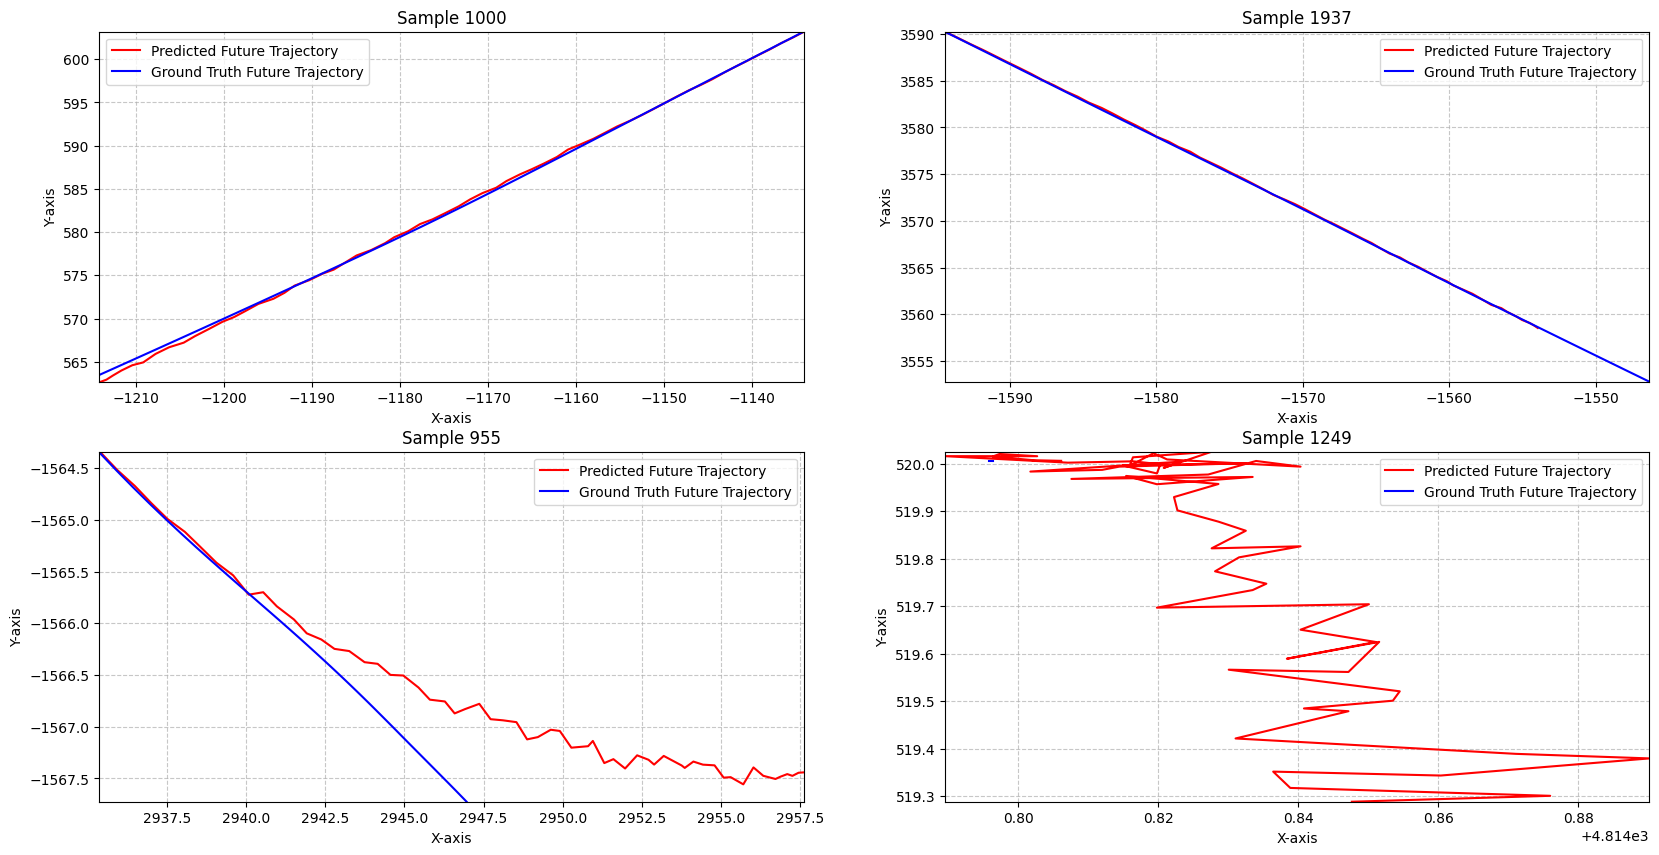

In [24]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [25]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = AdvancedTransformerModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
model = S4TrajectoryModel(
    input_dim=6,
    model_dim=256,
    num_layers=4,
    seq_len=50,
    future_len=60,
    dropout=0
).to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())

pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B